# Setting up Fastai

Importing fastai and downgrading to lower PyTorch version.

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs
!pip install "torch==1.4" "torchvision==0.5.0"

# Building ResBlock

In [2]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [3]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        self.conv=conv_layer(nf, nf, bias=True, norm_type=None) 
        
    def forward(self, x):
      x=self.conv(x)
      return x + self.conv2(self.conv1(x))

## Building RetinaNet

RetinaNet is an object detection model building upon ResNet and uses a Feature Pyramid Network to generate a convolutional feature pyramid in which there is attached two subnetworks. 

One of these networks is for classifying anchor boxes and the other is for regressing anchor boxes to ground-truth objects.

In [4]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        self.res=conv2d(chs,chs,3,stride=1)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        #layers = [ResBlock(chs) for _ in range(n_conv)]
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

## Create anchors

Anchors are points on a grid that we will use to determine where the bounding boxes has to be.

In [5]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))


def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

## Draw on image

Functionality for drawing squares on the images.

In [6]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')

## Display and compute anchors

Calculate where the bounding boxes has to be drawn as well as their IoU values (how much they overlap each other).

In [7]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

## Create RetinaNet loss function

In [8]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    # def _unpad(self, bbox_tgt, clas_tgt):
    #     i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
    #     return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
        
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt - self.pad_idx)) if sum(clas_tgt)>0 else 0
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:] - 1 + self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [9]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [10]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
# scales = [1,2**(1/3), 2**(2/3)] #for bigger size

In [11]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]
  
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [12]:
# def unpad(tgt_bbox, tgt_clas, pad_idx=0):
#     i = torch.min(torch.nonzero(tgt_clas-pad_idx))
#     return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

def _unpad(self, bbox_tgt, clas_tgt):
    i = torch.min(torch.nonzero(clas_tgt - self.pad_idx)) if sum(clas_tgt)>0 else 0
    return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:] - 1 + self.pad_idx

def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds
def show_preds(img, output, idx, detect_thresh=0.35, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: fig, ax = plt.subplots(1,1)
    axs=img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')
 
def show_results(learn, start=0, n=3, detect_thresh=0.35, figsize=(10,25)):
    x,y = next(iter(learn.data.valid_dl)) #one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 1, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        #img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i])

# Data manipulation

## Mounting Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

### Unzipping

In [ ]:
# !unzip -u drive/MyDrive/'Colab Notebooks/ZIP files/Self Driving Car.v3-fixed-small.coco.zip' -d drive/MyDrive/'Colab Notebooks/Data/Cars/'

### Moving json from training folder

In [ ]:
!mv 'drive/MyDrive/Colab Notebooks/Data/Cars/export/_annotations.coco.json' 'drive/MyDrive/Colab Notebooks/Data/Cars/'

mv: cannot stat 'drive/MyDrive/Colab Notebooks/Data/Cars/export/_annotations.coco.json': No such file or directory


In [ ]:
ls -l 'drive/MyDrive/Colab Notebooks/Data/Cars/'*.json

-rw------- 1 root root 37640268 Mar 10  2020 'drive/MyDrive/Colab Notebooks/Data/Cars/_annotations.coco.json'


### Setting path to image folder

In [14]:
path=Path('drive/MyDrive/Colab Notebooks/Data/Cars/')

## Loading image annotations

In [15]:
import json

trn_j = json.load((path/'_annotations.coco.json').open())
trn_j.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [16]:
images,annotations,categories = ['images','annotations','categories']

In [ ]:
trn_j[images][0]

In [ ]:
len(trn_j[images])

In [ ]:
trn_j[annotations][0]

In [ ]:
len(trn_j[annotations])

In [ ]:
trn_j[categories]

In [ ]:
len(trn_j[categories])

## Filtering data

### Create list of file names which has annotations.

In [17]:
file_name,id,img_id,cat_id,bbox = 'file_name','id','image_id','category_id','bbox'

trn_img_ids = [o[img_id] for o in trn_j[annotations]]

unique_ids = set(trn_img_ids)
trn_fns_unique_ids = [i for i in unique_ids]

trn_fns_id = [o[id] for o in trn_j[images]]
trn_fns_fn = [o[file_name] for o in trn_j[images]]
trn_fns_fn_id = list(zip(trn_fns_id, trn_fns_fn))

trn_fns = [i[1] for i in trn_fns_fn_id if i[0] in trn_fns_unique_ids]

### Delete unwanted images.

In [ ]:
# trn_fns_delete_files = [i for i in trn_fns_fn if i not in trn_fns]

In [ ]:
# for i in trn_fns_delete_files:
#   try:
#     os.remove('/content/drive/MyDrive/Colab Notebooks/Data/Cars/export/' + i)
#   except:
#     print('Error at ' + i)

### Zipping the list of annotated images with their respected bounding box values

In [18]:
images_trn,lbl_bbox_trn=get_annotations(path/'_annotations.coco.json')
lbl_bbox=lbl_bbox_trn
img2bbox = dict(zip(trn_fns, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [19]:
def get_data(bs, size):
  src = ObjectItemList.from_folder(path/'export')
  src = src.split_by_rand_pct(0.4,seed=2)
  src = src.label_from_func(get_y_func)
  src = src.transform(get_transforms(), size=size, tfm_y=True)
  return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

# Display batch sample

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


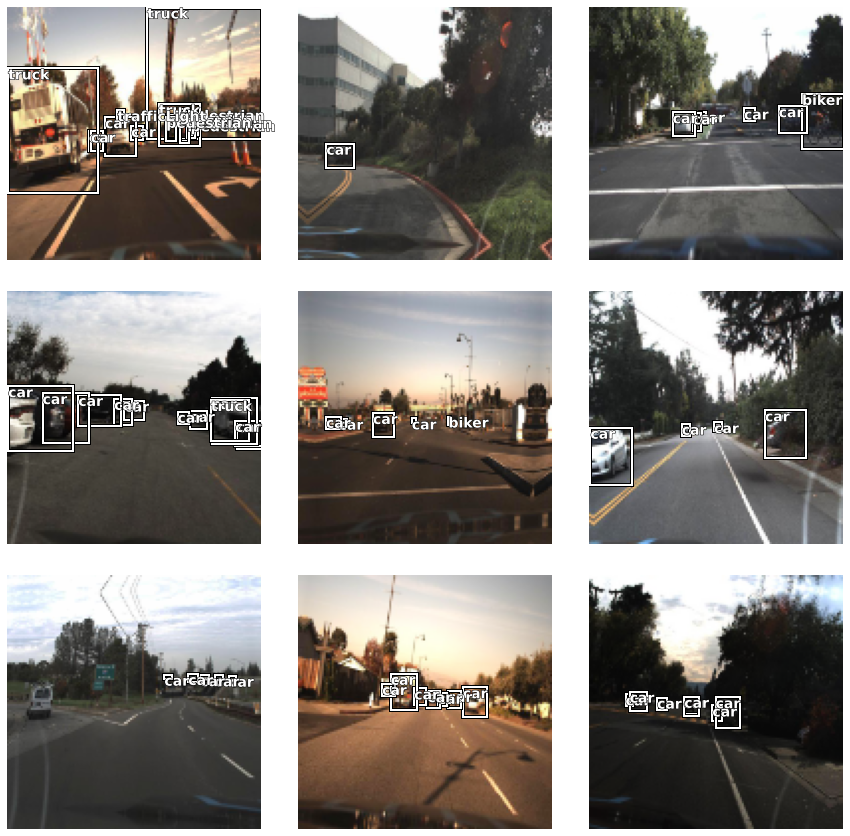

In [20]:
data = get_data(64,128)
data.show_batch(rows=3)

# Create learner based on RetinaNet

In [21]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [22]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [23]:
learn = learn.split(retina_net_split)

## Training

### Debug Out of Memory

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.6 GB  |     Proc size: 2.0 GB
GPU RAM Free: 10982MB | Used: 459MB | Util   4% | Total     11441MB


## Find Learning rate

In [ ]:
learn.freeze()
learn.save('stage-0')

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


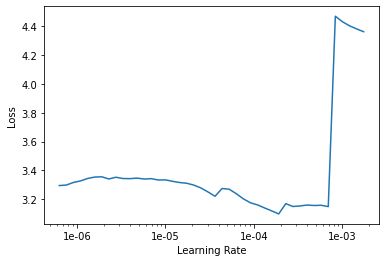

In [ ]:
learn.recorder.plot()

## Fine turning

In [ ]:
learn = learn.load('stage-0')

In [ ]:
learn.fit_one_cycle(10,max_lr=(4e-4), pct_start=0.8)

epoch,train_loss,valid_loss,time
0,2.372360,2.258969,13:43
1,1.978313,1.655697,05:13
2,1.532820,1.320511,05:14
3,1.289616,1.288068,05:15
4,1.119344,0.981065,05:15
5,1.103997,1.035723,05:16
6,0.995536,0.848817,05:15
7,0.943265,0.824874,05:15
8,0.868626,0.764294,05:15
9,0.776386,0.711596,05:16


In [ ]:
learn.fit_one_cycle(5, max_lr=(1e-4))

epoch,train_loss,valid_loss,time
0,0.752578,0.729032,05:17
1,0.749534,0.703780,05:17
2,0.725929,0.662285,05:17
3,0.698704,0.671640,05:15
4,0.694300,0.661299,05:15


In [ ]:
learn.save('stage-1-128')
learn=learn.load('stage-1-128')
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5,max_lr=slice(1e-6,5e-5),wd=0.1)

epoch,train_loss,valid_loss,time
0,0.678424,0.660980,05:29
1,0.682555,0.637388,05:27
2,0.669539,0.620335,05:27
3,0.647839,0.631366,05:26
4,0.643494,0.618361,05:26


In [ ]:
learn.save('stage-2-128')

In [ ]:
learn=learn.load('stage-2-128')

In [ ]:
learn.data = get_data(32,192)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


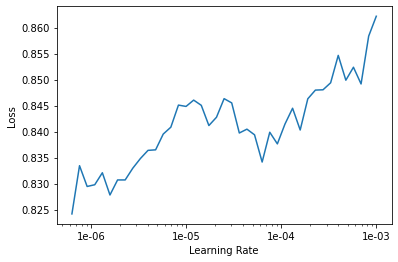

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,5e-5)

epoch,train_loss,valid_loss,time
0,0.789636,0.747257,08:16
1,0.754189,0.719629,08:15
2,0.735641,0.695408,08:16
3,0.712848,0.679594,08:15
4,0.691196,0.669170,08:22
5,0.672254,0.646864,08:19
6,0.660691,0.635468,08:20
7,0.646692,0.646163,08:22
8,0.636073,0.635699,08:21
9,0.645145,0.635715,08:20


In [ ]:
learn.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,time
0,0.669853,0.652957,08:20
1,0.676315,0.639512,08:20


In [ ]:
learn.save('stage-1-192')

In [ ]:
learn=learn.load('stage-1-192')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2,max_lr=slice(1e-4,5e-4),wd=0.1)

In [ ]:
learn.save('stage-2-192')

In [ ]:
learn=learn.load('stage-2-192')

In [25]:
learn.data=get_data(24,256)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,1e-5)

In [ ]:
learn.fit_one_cycle(3,1e-5)

In [ ]:
learn.save('stage-1-256')

In [26]:
learn=learn.load('stage-1-256')

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


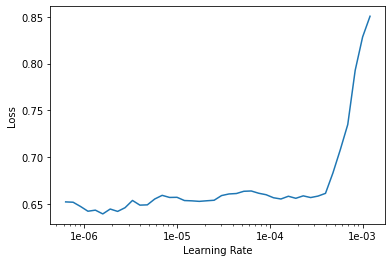

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10,max_lr=slice(1e-5,5e-5),wd=0.1)

epoch,train_loss,valid_loss,time
0,0.645950,0.611335,22:52
1,0.656792,0.604118,07:13
2,0.632400,0.600813,07:23
3,0.619777,0.583280,07:23
4,0.604613,0.610978,07:21
5,0.569191,0.549718,07:17
6,0.540223,0.547170,07:16
7,0.527198,0.538132,07:16
8,0.523622,0.535522,07:23
9,0.510464,0.532288,07:22


In [33]:
learn.save('stage-2-256')

In [34]:
learn=learn.load('stage-2-256')

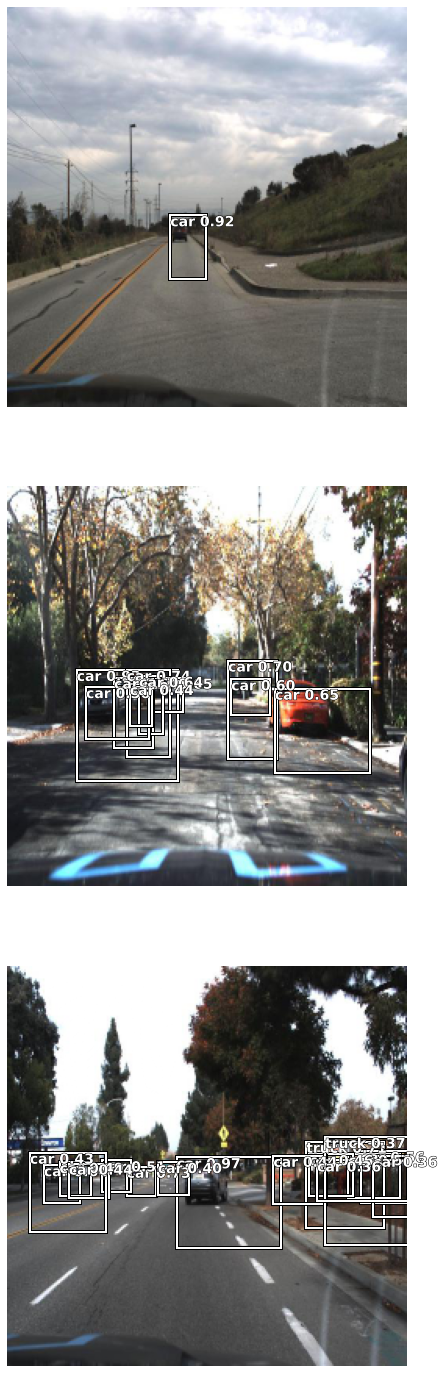

In [35]:
show_results(learn, start=0)

In [39]:
learn.export(os.path.abspath(path/'models/Car_detection.pkl'))